In [6]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
features = pd.read_csv('./train_features.csv', header=0)
features.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,...,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method
0,43373,NaN,12000,12000,36 months,16.02%,422.01,C,C5,Driver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
1,24414,NaN,6300,6300,36 months,14.07%,215.54,C,C3,GMP Lead,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
2,46723,NaN,4500,4500,36 months,7.21%,139.38,A,A3,Accounts,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
3,24878,NaN,12000,12000,36 months,9.44%,384.06,B,B1,Client Processing Associate,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
4,39038,NaN,12000,12000,36 months,22.35%,460.47,D,D5,Construction Operator,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash


In [8]:
target = pd.read_csv('./train_labels.csv', header=0)
target.head()

,id,charged_off
0,43373,0
1,24414,0
2,46723,0
3,24878,0
4,39038,0


In [9]:
train = features.merge(target)
print('train.shape:', train.shape)
train.head()

train.shape: (37745, 104)


,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,...,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method,charged_off
0,43373,NaN,12000,12000,36 months,16.02%,422.01,C,C5,Driver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0
1,24414,NaN,6300,6300,36 months,14.07%,215.54,C,C3,GMP Lead,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0
2,46723,NaN,4500,4500,36 months,7.21%,139.38,A,A3,Accounts,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0
3,24878,NaN,12000,12000,36 months,9.44%,384.06,B,B1,Client Processing Associate,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0
4,39038,NaN,12000,12000,36 months,22.35%,460.47,D,D5,Construction Operator,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0


In [10]:
def wrangle(d):
    def sub_grade_to_float(x):
        return float(ord(x[0]) - 64) + float(x[1:]) / 10
    
    df = d.copy()
    df.sub_grade = df.sub_grade.apply(sub_grade_to_float)
    df.int_rate = df.int_rate.apply(lambda x: float(x.strip()[:-1]))
    df.dti = df.dti.fillna(df.dti.median())
    df.all_util = df.all_util.fillna(df.all_util.median())
    df.avg_cur_bal = df.avg_cur_bal.fillna(df.avg_cur_bal.median())
    df.zip_code = df.zip_code.apply(lambda x: int(x[:3]))
    
    # A nan value is considered a float, so if there are nan values
    # in any feature that is not float, you have to process those
    # values specially, before you can process the non-nan values.
    # Instead, you can create a loop and an if statement to process
    # each value depending on it's type.
    res = []
    for i in range(len(df.revol_util)):
        if isinstance(df.revol_util[i], float):
            res.append(0.0)
        else:
            res.append(float(df.revol_util[i].strip('%')))
    df.revol_util = res
    df.application_type = (df.application_type == 'Joint App').astype(int)
    
    return df

In [11]:
def SHAP_impact_on_model_output(X_train, X_val, y_train, y_val, model):
    shap.initjs()

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)
    shap.summary_plot(shap_values, X_val)
    shap.summary_plot(shap_values, X_val, plot_type="bar")


def split_data(df, target, include_features,
               test_size=0.2):
    
    if isinstance(include_features, str):
        df_lim_features = df.select_dtypes(include=include_features)
    else:  # must be a list of features we selected
        df_lim_features = df.loc[:, include_features]
        
    print('Limited features df:', df_lim_features.shape)
    print(df_lim_features.head(), end='\n\n')
    if target in df_lim_features.columns:
        X = df_lim_features.drop(target, axis=1)
        y = df_lim_features[target]
    else:  # When features are categorical, but target is numerical or vice versa
        X = df_lim_features
        y = df[target]
        
    X_train, X_val, y_train, y_val = train_test_split(
                                        X, y, test_size=0.2,
                                        random_state=20)
    return X_train, X_val, y_train, y_val

In [12]:
def feature_rankings(df, target, clf, include_features):
    X_train, X_val, y_train, y_val = \
        split_data(df, target, include_features=include_features, test_size=0.2)

    encoder = ce.OrdinalEncoder()
    X_train = encoder.fit_transform(X_train)
    X_val = encoder.transform(X_val)
    model = clf.fit(X_train, y_train)
    
    print('Classifier score:', model.score(X_val, y_val))
    SHAP_impact_on_model_output(X_train, X_val, y_train, y_val, model)

Limited features df: (37745, 92)
      id  member_id  loan_amnt  funded_amnt  int_rate  installment  sub_grade  \
0  43373        NaN      12000        12000     16.02       422.01        3.5   
1  24414        NaN       6300         6300     14.07       215.54        3.3   
2  46723        NaN       4500         4500      7.21       139.38        1.3   
3  24878        NaN      12000        12000      9.44       384.06        2.1   
4  39038        NaN      12000        12000     22.35       460.47        4.5   

   annual_inc  url  desc  ...  sec_app_inq_last_6mths  sec_app_mort_acc  \
0     81000.0  NaN   NaN  ...                     NaN               NaN   
1     39000.0  NaN   NaN  ...                     NaN               NaN   
2     78000.0  NaN   NaN  ...                     NaN               NaN   
3     62000.0  NaN   NaN  ...                     NaN               NaN   
4     70000.0  NaN   NaN  ...                     NaN               NaN   

   sec_app_open_acc  sec_app_

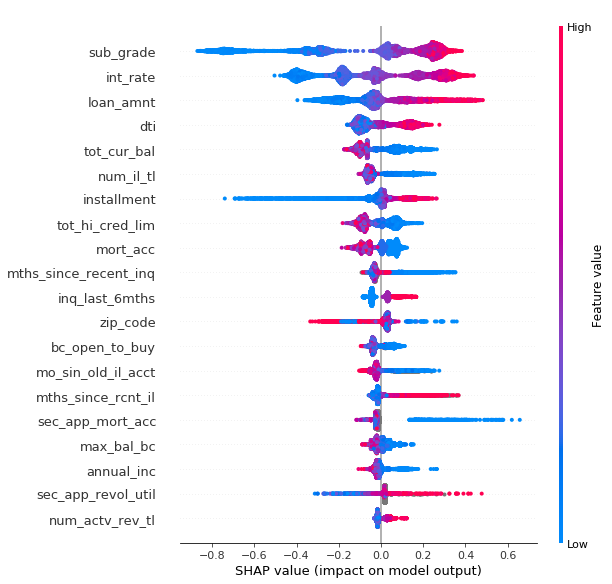

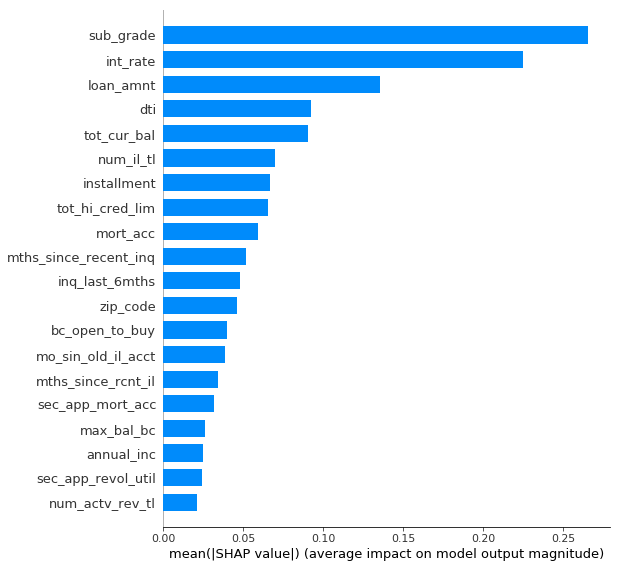

Limited features df: (37745, 12)
         term grade                    emp_title emp_length home_ownership  \
0   36 months     C                       Driver    4 years       MORTGAGE   
1   36 months     C                     GMP Lead    4 years           RENT   
2   36 months     A                    Accounts     3 years           RENT   
3   36 months     B  Client Processing Associate  10+ years       MORTGAGE   
4   36 months     D       Construction Operator   10+ years       MORTGAGE   

              purpose               title addr_state earliest_cr_line  \
0  debt_consolidation  Debt consolidation         NC         Dec-2005   
1  debt_consolidation  Debt consolidation         CA         Mar-2012   
2  debt_consolidation  Debt consolidation         CA         May-2000   
3  debt_consolidation  Debt consolidation         OH         Feb-2003   
4  debt_consolidation  Debt consolidation         TX         Nov-2001   

  initial_list_status sec_app_earliest_cr_line disbursement

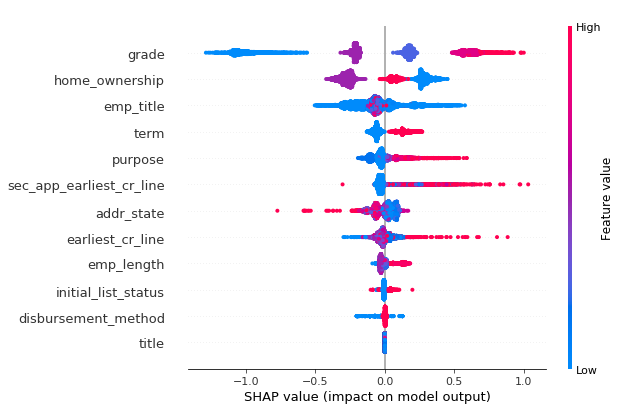

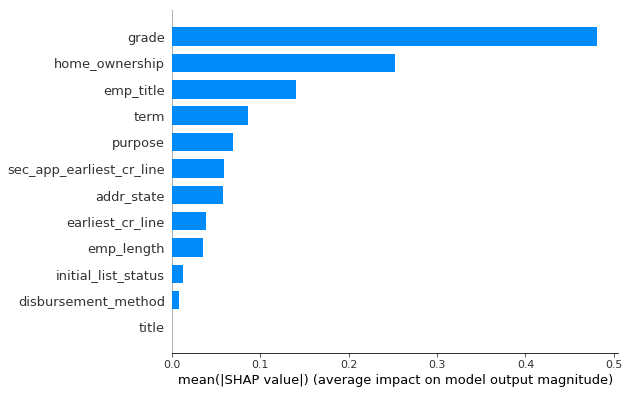

In [13]:
df = wrangle(train)
xgb = XGBClassifier()
feature_rankings(df, 'charged_off', xgb, 'number')
feature_rankings(df, 'charged_off', xgb, 'object')

### The red values in this plot says that the value of that feature is high. For the top feature (tot_hi_cred_lim), the red spots are to the left of the median line. This means this feature being high moves the output towards lesser values (i.e. towards 0 or paid off rather than 1 which is charged-off).
### We can also plot the mean absolute SHAP values as shown below

Limited features df: (37745, 7)
   sub_grade  int_rate  loan_amnt grade home_ownership  \
0        3.5     16.02      12000     C       MORTGAGE   
1        3.3     14.07       6300     C           RENT   
2        1.3      7.21       4500     A           RENT   
3        2.1      9.44      12000     B       MORTGAGE   
4        4.5     22.35      12000     D       MORTGAGE   

                     emp_title        term  
0                       Driver   36 months  
1                     GMP Lead   36 months  
2                    Accounts    36 months  
3  Client Processing Associate   36 months  
4       Construction Operator    36 months  

Classifier score: 0.8562723539541661


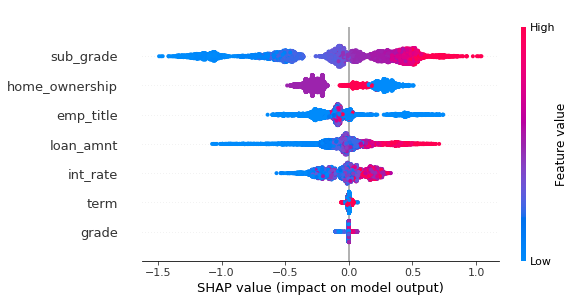

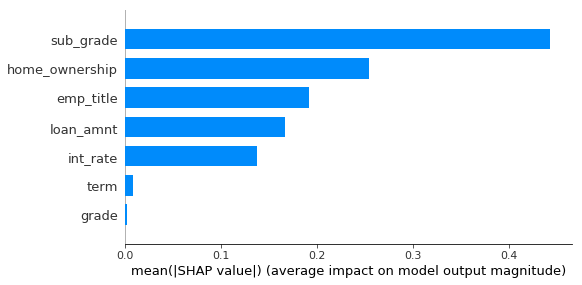

In [14]:
use_cols = ['sub_grade', 'int_rate', 'loan_amnt',
            'grade', 'home_ownership', 'emp_title', 'term']
xgb = XGBClassifier()
feature_rankings(df, 'charged_off', xgb, use_cols)

### Can't get beyond 85%. Maybe we should change tactics and look at correlation between features and Seaborn pairplots

#### Select the top correlated numerical features

In [15]:
df = wrangle(train)
df_numerical = df.select_dtypes(include='number')
use_numerical_cols = abs(df_numerical.corr()['charged_off'][:]) \
                         .sort_values(ascending=False).index

#### Visually select the most correlated categorical features

In [16]:
x_vars=train.drop(['charged_off'], axis=1) \
            .loc[:, train.columns.difference(use_numerical_cols)] \
            .columns.values
x_vars

array(['addr_state', 'disbursement_method', 'earliest_cr_line',
       'emp_length', 'emp_title', 'grade', 'home_ownership',
       'initial_list_status', 'purpose', 'sec_app_earliest_cr_line',
       'term', 'title'], dtype=object)

In [17]:
# type(list(x_vars))
# type(list(['charged_off']))
# sns.pairplot(train, x_vars=list(x_vars), y_vars=['charged_off'])

#### For some reason, pairplot could not be drawn even after 10 minutes. Maybe I need to wait a lot more. Will try again when I have more time.

### Use grid search to find the optimum XGBoost classifier

In [19]:
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators':  [100, 500, 1000],
#     'max_depth': [3, 4, 5, 6],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
#     'gamma': [0, 1, 5]
# }

X_train, X_val, y_train, y_val = \
    train_test_split(df.drop(['charged_off'], axis=1), df['charged_off'], 
                     test_size=0.2, random_state=20)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)
# model = clf.fit(X_train, y_train)

param_grid = {
    'learning_rate': [0.01],
    'n_estimators':  [100, 1000],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.3, 0.9],
    'gamma': [0, 5]
}

gridsearch = GridSearchCV(XGBClassifier(),
                          param_grid=param_grid, 
                          scoring='accuracy', cv=3, 
                          return_train_score=True, verbose=10)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8, score=0.8519769521160342, total=   2.0s
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8, score=0.8520615996025832, total=   2.0s
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8, score=0.8520615996025832, total=   2.0s
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0, score=0.852076296443473, total=   1.9s
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.1s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0, score=0.8520615996025832, total=   1.8s
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.0s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0, score=0.8520615996025832, total=   1.8s
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.9s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8, score=0.8538644943373733, total=  18.3s
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   30.9s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8, score=0.8539493293591655, total=  18.1s
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   49.8s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8, score=0.7773472429210134, total=  18.3s
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0, score=0.854261871647129, total=  17.8s
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0 
[CV]  colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0, score=0.8536512667660209, total=  18.0s
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0 
[CV]  colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0, score=0.7504222553402882, total=  17.1s
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8 
[CV]  colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8, score=0.8528710510629843, total=   3.8s
[CV] colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.8, score=0.854942871336314, total=  34.2s
[CV] colsample_bytree=0.3, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.8 
[CV]  colsample_bytree=0.3, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.8, score=0.7556880278191753, total=  33.6s
[CV] colsample_bytree=0.3, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=1.0 
[CV]  colsample_bytree=0.3, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=1.0, score=0.854261871647129, total=  31.9s
[CV] colsample_bytree=0.3, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=1.0 
[CV]  colsample_bytree=0.3, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=1.0, score=0.8543467461500248, total=  32.1s
[CV] colsample_bytree=0.3, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=1.0 
[CV]  colsampl

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0, score=0.8520615996025832, total=   3.9s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8, score=0.8539638386648123, total=  42.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8, score=0.85424739195231, total=  42.5s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.8, score=0.777645305514158, total=  42.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0 
[CV]  colsample_

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 39.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.01], 'n_estimators': [100, 1000], 'max_depth': [3, 6], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.3, 0.9], 'gamma': [0, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [ ]:
grid_search.fit(X_train, y_train)
print('  Best score from grid search:', grid_search.score(X_test, y_test))